```python   
Project Aeacus
Created by Gil on 9/24/2025
Updated by Gil on 9/29/2025
```

# Bond2Vec: A Multi-Task Learning Framework for Municipal Bond Embeddings

## Overview

Bond2Vec learns municipal bond embeddings from **market behavior** rather than static attributes. Using a **Siamese neural network**, bonds are mapped into a low-dimensional space where proximity reflects **how they trade together**.

This framework:

* Builds **positive/negative training pairs** by computing short trade histories dot product, TODO: try longer trade history matrix
* Uses a **shared neural encoder** to embed each bond’s reference features.
* Trains embeddings so that bonds with similar behavior are close in space.
* Allows downstream tasks like arbitrage discovery, portfolio clustering, and cold-start pricing.



## Core Concepts

### 1. Pair Creation via Trade Histories

* Each bond has a **5×6 trade-history matrix** encoding its last 5 trades:

| Feature            | Description                 | Example   |
| ------------------ | --------------------------- | --------- |
| Yield Spread       | Bond yield – FICC curve     | 101.4 bps |
| Treasury Spread    | Bond yield – Treasury yield | 19.0 bps  |
| log₁₀(Par)         | Normalized trade size       | 4.7       |
| Trade Type 1/2     | Encoded trade directions    | 0, 1      |
| log₁₀(Seconds Ago) | Time since trade            | 2.18      |

* We flatten each matrix into a vector `h(x)`.
* Compute **cosine similarity** between two bonds’ histories:

$$
s(x, x') = \frac{h(x) \cdot h(x')}{\|h(x)\|\|h(x')\|}
$$

* If `s > 0.5`: positive pair (similar behavior).
* If `s < 0.2`: negative pair.

> This step produces **labels** for training. At inference, only ref features (coupon, rating, state, etc.) and sythetic trades features are needed.



### 2. Embedding Framework

We formalize prediction tasks as:

* **Unary tasks** (e.g. “Will this bond trade tomorrow?”)
  $\mathcal{Z}_t = \mathcal{X}$, $\mathcal{Y}_t \in \mathbb{R} \text{ or } \{-1,+1\}$
* **Binary tasks** (e.g. “Will bonds co-trade?”)
  $\mathcal{Z}_t = \mathcal{X} \times \mathcal{X}$

We embed each bond into a $k$-dimensional space:

$$
g : \mathcal{X} \to \mathbb{R}^k, \quad k < d
$$

and define a task-specific predictor:

$$
f_t(x, x') = g(x)^\top M_t g(x') + b_t
$$

* $g(x)$: embedding of bond $x$
* $M_t$: learned matrix (not forced symmetric → allows directionality)
* $b_t$: bias

Interpretation: $f_t(x, x')$ is high when embeddings are behaviorally similar.



### 3. Siamese Neural Network

The encoder $g(x)$ is implemented as a **Siamese network**: two identical subnetworks with shared weights.

**Architecture**:

* Input: ~301 engineered features per bond
* Hidden layers: 512 → 256 → 256 (ReLU + BatchNorm + Dropout)
* Output: 128-dim embedding, L2-normalized

**Diagram (conceptual)**:

```
CUSIP A features ─▶ Base Network ─▶ Embedding A ─┐
                                                 ├─▶ Dot Product → Similarity Score
CUSIP B features ─▶ Base Network ─▶ Embedding B ─┘
```

Training uses **contrastive loss**:

$$
\ell(y,\hat{y}) = y(1-\hat{y})^2 + (1-y)\max(0,\hat{y}-m)^2
$$

* $y = 1$ for similar, $0$ otherwise
* $\hat{y}$: predicted similarity
* $m$: margin to separate negatives

Errors backpropagate into the encoder, shaping the embedding space.



## How to Read This Notebook

* **Linear algebra primer**:

  * Dot product = similarity measure.
  * Cosine similarity = dot product of normalized vectors.
* **Pair creation**: Dot products on short trade histories → labels.
* **Siamese network**: Learns embeddings from reference data.
* **Embeddings**: At inference, you only need static bond features; the network places bonds into a latent behavioral space.



## Production Use Cases (Condensed)

* **Arbitrage scanner**: flag pairs with high similarity but yield gaps.
* **Easy new issue pricing
* **Liquidity Score
* **Price illiquids
* **Improve accuracy of current models
* **Portfolio analysis**: measure concentration in “behavioral clusters.”
* **pricing**: estimate fair value for illiquid bonds.
* **Anomaly detection**: spot bonds diverging from their peers.


```

### Array Structure

[yield_spread, treasury_spread, log_par_traded, trade_type_1, trade_type_2, log_seconds_ago]
```

### Feature Breakdown

| Index | Feature | Description | Example Value |
|-------|---------|-------------|---------------|
| 0 | **Yield Spread** | Bond yield × 100 - FICC yield curve level (basis points) | 101.42 |
| 1 | **Treasury Spread** | (Bond yield - Treasury rate) × 100 (basis points, rounded to 3 decimals) | 19.0 |
| 2 | **Log Par Traded** | log₁₀(trade size) - normalizes trade sizes | 4.70 |
| 3 | **Trade Type 1** | First component of trade type encoding | 0.0 |
| 4 | **Trade Type 2** | Second component of trade type encoding | 0.0 |
| 5 | **Log Seconds Ago** | log₁₀(1 + seconds since trade) - normalizes time decay | 2.18 |




In [6]:
# Cell 1: Environment Setup - Set CUDA paths BEFORE importing TensorFlow
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add modules folder to path
sys.path.append('./modules')

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/gil/git/ficc/creds.json"

# CRITICAL: Set CUDA paths BEFORE importing TensorFlow
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda-12/lib64:/usr/local/cuda/lib64'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TF logging

print("Environment setup complete")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Environment setup complete


In [7]:
# Cell 2: Import libraries (AFTER setting CUDA paths)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pickle
import random
import time
import redis
from multiprocessing import cpu_count

# NOW import TensorFlow (after CUDA paths are set)
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity

# Set seeds
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Check GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print(f"CPUs available: {cpu_count()}")

# If GPU found, show which one
if tf.config.list_physical_devices('GPU'):
    print(f"GPU Details: {tf.config.experimental.get_device_details(tf.config.list_physical_devices('GPU')[0])}")

TensorFlow version: 2.16.1
GPU Available: []
CPUs available: 10


In [8]:
# Cell 3: Import Custom Modules
# Import our custom modules from the modules folder
from modules.bond_embedding_helpers import *
from modules.feature_engineering import *
from modules.pair_generation import *
from modules.siamese_network import *
from modules.redis_embedder import RedisCusipEmbedder

In [9]:
# Cell 4: Configuration
# Configuration parameters
EMBEDDING_DIM = 128
BATCH_SIZE = 8096
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
TIME_WINDOW_SECONDS = 30
MIN_SIMILARITY = 0.5
MAX_PAIRS_PER_WINDOW = 500

print("Configuration:")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Time window: {TIME_WINDOW_SECONDS} seconds")
print(f"  Min similarity threshold: {MIN_SIMILARITY}")

Configuration:
  Embedding dimension: 128
  Batch size: 8096
  Time window: 30 seconds
  Min similarity threshold: 0.5


In [7]:
# Cell 5: Load Data
DATA_PATH = '2025-09-22_one_month.pkl'

print("Loading data...")
df = pd.read_pickle(DATA_PATH)

print(f"✓ Loaded {len(df):,} trades")
print(f"  Unique CUSIPs: {df['cusip'].nunique():,}")
print(f"  Date range: {df['trade_datetime'].min()} to {df['trade_datetime'].max()}")
print(f"  Shape: {df.shape}")

Loading data...
✓ Loaded 1,405,865 trades
  Unique CUSIPs: 196,446
  Date range: 2025-08-20 06:00:01 to 2025-09-19 19:30:08
  Shape: (1405865, 148)


In [6]:
# Cell 6: Generate Pairs
print("="*60)
print("PAIR GENERATION")
print("="*60)

pairs_df = run_pair_generation_pipeline(
    df,
    time_window_seconds=TIME_WINDOW_SECONDS,
    min_similarity=MIN_SIMILARITY,
    max_pairs_per_window=MAX_PAIRS_PER_WINDOW,
    output_path='embedding_pairs_temporal.pkl',
    n_processes=cpu_count() - 1
)

PAIR GENERATION
Data shape: (1405865, 148)
Unique CUSIPs: 196446
Date range: 2025-08-20 06:00:01 to 2025-09-19 19:30:08
Time window: 30 seconds

Generating pairs with parallel processing...
Using 11 processes for pair generation
Processing 25439 time windows
Pair generation completed in 156.87 seconds

Generated:
  Positive pairs: 3,871,757
  Negative pairs: 2,662,012

Final dataset shape: (6533769, 9)
Positive ratio: 59.26%

Saved to embedding_pairs_temporal.pkl

Similarity statistics:
Positive pairs - Mean similarity: 0.824
Positive pairs - Std:  0.146
Negative pairs - Mean similarity: -0.257
Negative pairs - Std:  0.290

Temporal statistics:
Earliest pair: 2025-08-20 07:19:30
Latest pair: 2025-09-19 16:59:30
Number of unique time windows: 24245


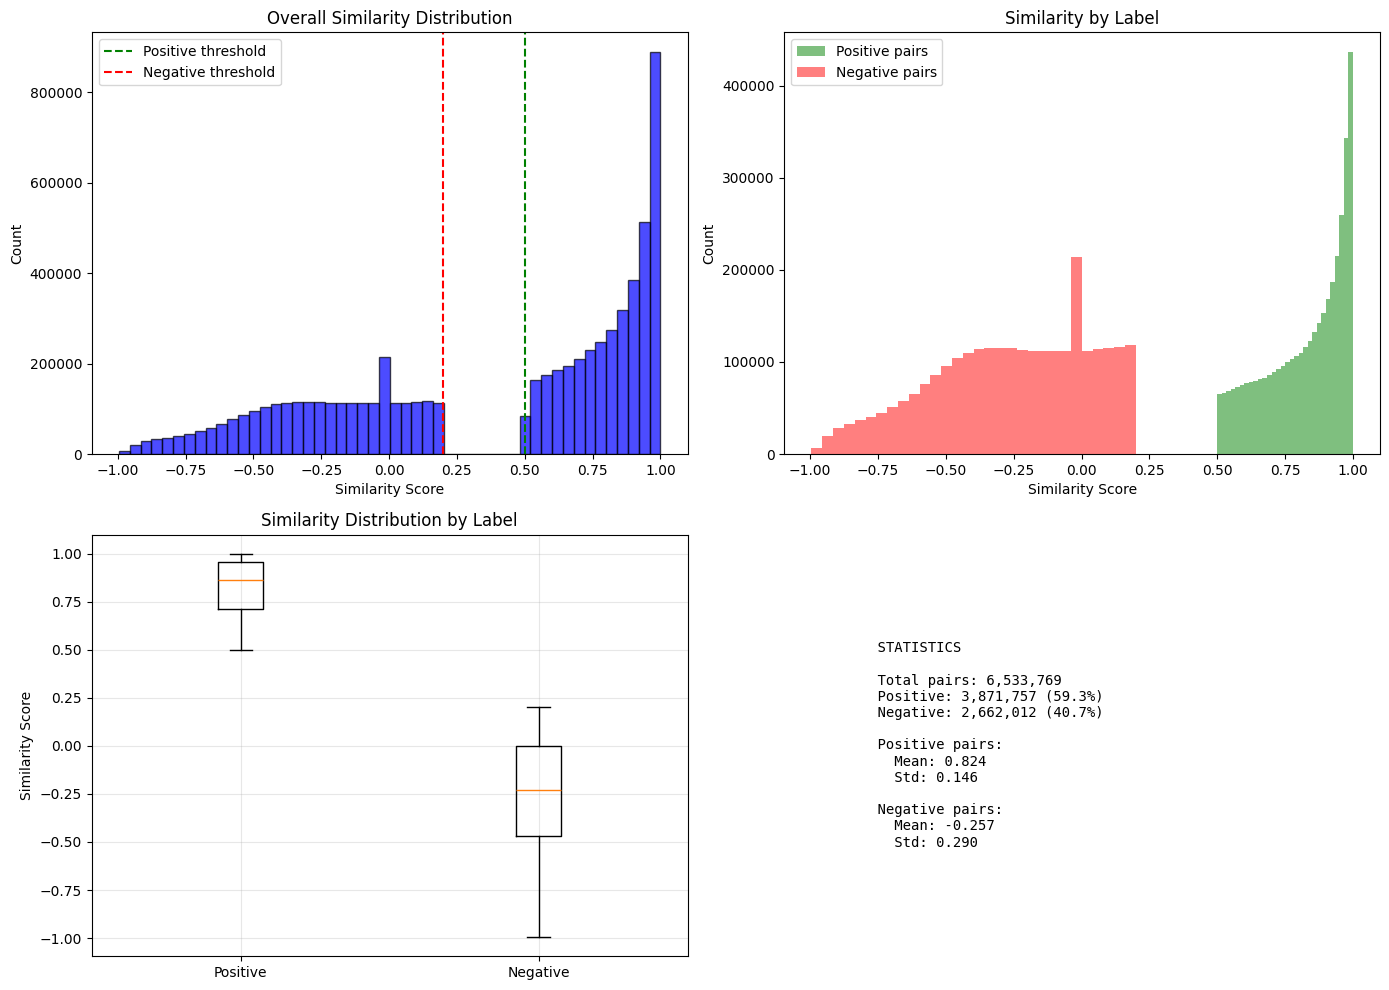

In [7]:
# Cell 7: Visualize Pair Distributions
def visualize_pair_distributions(pairs_df):
    """Visualize the distribution of similarities"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Overall distribution
    ax = axes[0, 0]
    ax.hist(pairs_df['similarity'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(x=0.5, color='green', linestyle='--', label='Positive threshold')
    ax.axvline(x=0.2, color='red', linestyle='--', label='Negative threshold')
    ax.set_xlabel('Similarity Score')
    ax.set_ylabel('Count')
    ax.set_title('Overall Similarity Distribution')
    ax.legend()
    
    # Separate distributions
    ax = axes[0, 1]
    pos_pairs = pairs_df[pairs_df['label'] == 1]
    neg_pairs = pairs_df[pairs_df['label'] == 0]
    
    ax.hist(pos_pairs['similarity'], bins=30, alpha=0.5, label='Positive pairs', color='green')
    ax.hist(neg_pairs['similarity'], bins=30, alpha=0.5, label='Negative pairs', color='red')
    ax.set_xlabel('Similarity Score')
    ax.set_ylabel('Count')
    ax.set_title('Similarity by Label')
    ax.legend()
    
    # Box plot
    ax = axes[1, 0]
    data_to_plot = [pos_pairs['similarity'], neg_pairs['similarity']]
    ax.boxplot(data_to_plot, labels=['Positive', 'Negative'])
    ax.set_ylabel('Similarity Score')
    ax.set_title('Similarity Distribution by Label')
    ax.grid(True, alpha=0.3)
    
    # Statistics
    ax = axes[1, 1]
    ax.axis('off')
    
    stats_text = f"""
    STATISTICS
    
    Total pairs: {len(pairs_df):,}
    Positive: {len(pos_pairs):,} ({len(pos_pairs)/len(pairs_df):.1%})
    Negative: {len(neg_pairs):,} ({len(neg_pairs)/len(pairs_df):.1%})
    
    Positive pairs:
      Mean: {pos_pairs['similarity'].mean():.3f}
      Std: {pos_pairs['similarity'].std():.3f}
    
    Negative pairs:
      Mean: {neg_pairs['similarity'].mean():.3f}
      Std: {neg_pairs['similarity'].std():.3f}
    """
    
    ax.text(0.1, 0.5, stats_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='center', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

# Visualize
visualize_pair_distributions(pairs_df)

In [ ]:
# Cell 8: Train Siamese Network
print("="*60)
print("TRAINING SIAMESE NETWORK")
print("="*60)

base_network, artifacts, history = run_training_pipeline(
    features_df=df,
    pairs_df=pairs_df,
    test_size=0.2,
    embedding_dim=EMBEDDING_DIM,
    epochs=NUM_EPOCHS
)

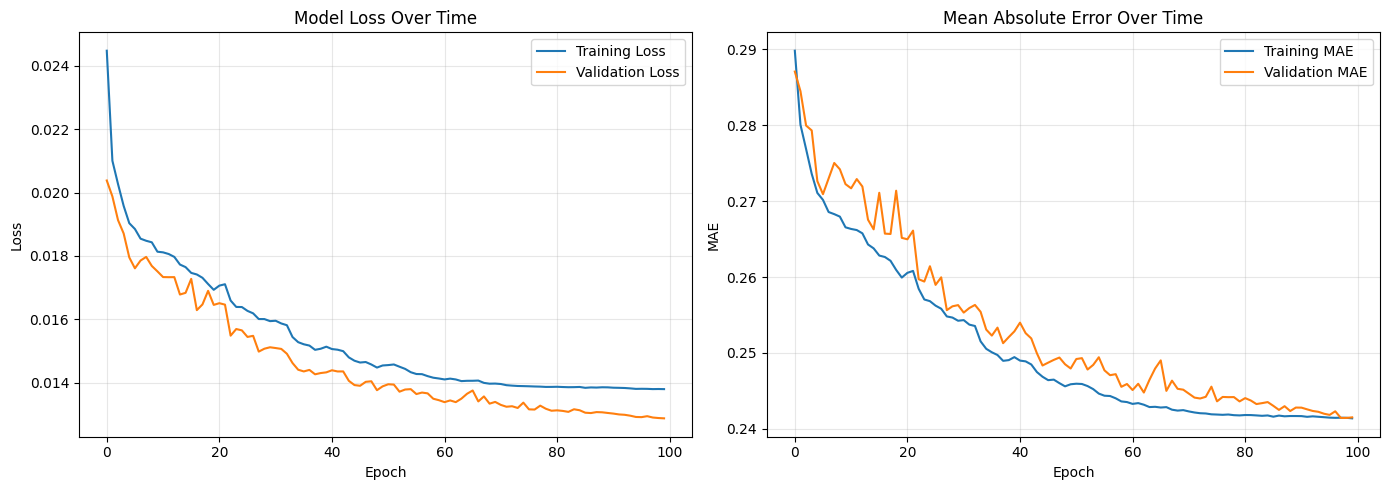

In [9]:
# Cell 9: Plot Training History
def plot_training_history(history):
    """Plot training and validation loss"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Loss plot
    ax = axes[0]
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Model Loss Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # MAE plot
    ax = axes[1]
    if 'mae' in history.history:
        ax.plot(history.history['mae'], label='Training MAE')
        ax.plot(history.history['val_mae'], label='Validation MAE')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MAE')
        ax.set_title('Mean Absolute Error Over Time')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

```markdown
## Starting from Analysis

If you're starting from this point, you'll need to load the pre-computed data:

### Required Data Files:
1. **Original trades data**: Contains all bond trades with features
2. **Trained embeddings**: 128-dimensional vectors for each CUSIP

### Load the Data:
```python
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the original trades data
DATA_PATH = '/home/gil/git/ficc/notebooks/gil_modeling/embeddings/2025-09-22_one_month.pkl'
df = pd.read_pickle(DATA_PATH)
print(f"Loaded {len(df):,} trades with {df['cusip'].nunique():,} unique CUSIPs")

# Load pre-computed embeddings
EMBEDDINGS_PATH = '/home/gil/git/ficc/notebooks/gil_modeling/embeddings/cusip_embeddings_final.csv'
embeddings_df = pd.read_csv(EMBEDDINGS_PATH)
print(f"Loaded {len(embeddings_df):,} CUSIP embeddings")
print(f"Embedding dimension: {len([c for c in embeddings_df.columns if c.startswith('emb_')])}")

# Configuration
EMBEDDING_DIM = 128
```

### What These Files Contain:
- **df**: 1.4M bond trades with trade histories, yields, ratings, and features
- **embeddings_df**: 196K unique CUSIPs with their 128-dim behavioral embeddings learned from 6.5M temporal pairs

In [ ]:
# Generate some Embeddings for Unique CUSIPs in the trades DF - not Prod: 

print("="*60)
print("GENERATING EMBEDDINGS")
print("="*60)

# Get unique CUSIPs (latest trade for each)
unique_cusips_df = df.sort_values('trade_datetime').groupby('cusip').last().reset_index()
print(f"Generating embeddings for {len(unique_cusips_df):,} unique CUSIPs")

# Generate embeddings
embeddings_df = get_embeddings(unique_cusips_df, base_network, artifacts)

# Save embeddings
embeddings_df.to_csv('cusip_embeddings_final.csv', index=False)
print(f"✓ Saved embeddings to cusip_embeddings_final.csv")
print(f"  Shape: {embeddings_df.shape}")

GENERATING EMBEDDINGS
Generating embeddings for 196,446 unique CUSIPs
Engineered 301 features from 196446 trades
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
✓ Saved embeddings to cusip_embeddings_final.csv
  Shape: (196446, 130)


In [25]:
# Embed the last N trades / days form tape (currently a file) 

import pandas as pd
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load the original trades data
DATA_PATH = '/Users/gil/git/ficc/notebooks/gil_modeling/embeddings/2025-09-22_one_month.pkl'
df = pd.read_pickle(DATA_PATH)
print(f"Loaded {len(df):,} trades with {df['cusip'].nunique():,} unique CUSIPs")

# Load pre-computed embeddings
EMBEDDINGS_PATH = '/Users/gil/git/ficc/notebooks/gil_modeling/embeddings/cusip_embeddings_final.csv'
embeddings_df = pd.read_csv(EMBEDDINGS_PATH)
print(f"Loaded {len(embeddings_df):,} CUSIP embeddings")
print(f"Embedding dimension: {len([c for c in embeddings_df.columns if c.startswith('emb_')])}")

# Configuration
EMBEDDING_DIM = 128

Loaded 1,405,865 trades with 196,446 unique CUSIPs
Loaded 202,010 CUSIP embeddings
Embedding dimension: 128


In [26]:
# Cell 11: Embedding Analysis Setup
print("="*60)
print("EMBEDDING ANALYSIS")
print("="*60)

# Merge embeddings with latest trade data for analysis
latest_trades = df.sort_values('trade_datetime').groupby('cusip').last().reset_index()
key_fields = ['cusip', 'yield', 'dollar_price', 'rating', 'maturity_date', 
              'coupon', 'incorporated_state_code', 'trade_datetime', 'par_traded']

available_fields = [f for f in key_fields if f in latest_trades.columns]
analysis_df = embeddings_df.merge(latest_trades[available_fields], on='cusip', how='inner')

# Clean yields
if 'yield' in analysis_df.columns:
    analysis_df['yield'] = analysis_df['yield'] / 100.0
    bad_yield_mask = (analysis_df['yield'] > 15) | (analysis_df['yield'] < 0)
    analysis_df.loc[bad_yield_mask, 'yield'] = np.nan

# Extract embedding matrix
embedding_cols = [c for c in embeddings_df.columns if c.startswith('emb_')]
X = analysis_df[embedding_cols].values
X_normalized = X / (np.linalg.norm(X, axis=1, keepdims=True) + 1e-12)

print(f"✓ Prepared {len(analysis_df):,} CUSIPs for analysis")
print(f"  Embedding dimension: {len(embedding_cols)}")

EMBEDDING ANALYSIS
✓ Prepared 184,558 CUSIPs for analysis
  Embedding dimension: 128


In [36]:
from modules.redis_embedder import RedisCusipEmbedder

embedder = RedisCusipEmbedder(
    model_path="cusip_embedding_model_temporal.keras",
    artifacts_path="feature_artifacts_temporal.pkl"
)

vec, meta = embedder.embed(
    cusip="45505KBJ8",
    trade_type="P",
    quantity=100
)

print("Embedding shape:", vec.shape)
print("128 dims:", vec)
print("Metadata:", meta)

Model expects 301 features
Engineered 301 features from 1 trades
Embedding shape: (128,)
128 dims: [-0.09686212 -0.04074094 -0.01772461  0.07226151 -0.10231287 -0.1116024
 -0.0809039   0.03663153  0.09661576  0.10543701  0.03448164  0.00882087
 -0.05579797  0.10022365  0.15029863 -0.05889768  0.02480182 -0.07009938
  0.10024581 -0.06119497 -0.06309215  0.04646152  0.06265919 -0.07106142
 -0.07137474 -0.02690436 -0.07418381  0.0945126   0.13536765  0.12564805
 -0.11568223  0.07463263  0.10400838  0.03956326  0.01543928 -0.1029624
  0.09465019 -0.12397093  0.09931975  0.07773574  0.1308482   0.08096973
  0.10609849  0.08409848 -0.09008189  0.05555829 -0.12114975 -0.10407486
 -0.09582742  0.13569613  0.07791825 -0.00902587 -0.16363262  0.02730387
  0.0801403  -0.0620837   0.00688328 -0.10851817  0.09425672 -0.06500755
  0.01783681  0.13794206 -0.08289047  0.04290661  0.11212553 -0.09536964
  0.13570334 -0.00588474 -0.11782582 -0.05722896  0.12815005  0.06984834
  0.052543    0.07855436 -0

In [28]:
# Cell 12: Fast Similarity Search with FAISS
import faiss
import numpy as np
import time

# Build FAISS index for fast similarity search
def build_faiss_index(embeddings_matrix):
    """Build FAISS index for cosine similarity search"""
    # Normalize embeddings for cosine similarity
    embeddings_norm = embeddings_matrix.copy()
    embeddings_norm = embeddings_norm / np.linalg.norm(embeddings_norm, axis=1, keepdims=True)
    
    # Create index (IndexFlatIP = Inner Product, which equals cosine sim for normalized vectors)
    dim = embeddings_matrix.shape[1]
    index = faiss.IndexFlatIP(dim)
    
    # Add vectors to index (must be float32)
    index.add(embeddings_norm.astype('float32'))
    
    return index, embeddings_norm

# Build the index
print("Building FAISS index...")
faiss_index, X_normalized_faiss = build_faiss_index(X)
print(f"✓ FAISS index built with {faiss_index.ntotal:,} vectors")

Building FAISS index...
✓ FAISS index built with 184,558 vectors


In [37]:
# Cell 13: Fast Find Similar Bonds Function using FAISS with Vector Input
def find_similar_bonds_fast(query_vector, n_similar=10, target_state=None, analysis_df=None, faiss_index=None):
    """
    Find similar bonds using FAISS with a query vector
    
    Args:
        query_vector: The embedding vector (numpy array) to search for
        n_similar: Number of similar bonds to return
        target_state: If provided, filter results to only bonds from this state
        analysis_df: DataFrame with bond characteristics
        faiss_index: Pre-built FAISS index
    
    Returns:
        DataFrame with similar bonds and their characteristics
    """
    
    # Ensure query vector is the right shape and type
    if query_vector.ndim == 1:
        query_vector = query_vector.reshape(1, -1)
    query_vector = query_vector.astype('float32')
    
    # Search for more candidates if we need to filter
    k = min(n_similar * 10 if target_state else n_similar, len(analysis_df))
    
    # FAISS search (this is the fast part!)
    similarities, indices = faiss_index.search(query_vector, k)
    
    # Filter results
    results_list = []
    for idx, sim in zip(indices[0], similarities[0]):
        # Apply state filter if requested
        if target_state and 'incorporated_state_code' in analysis_df.columns:
            if analysis_df.iloc[idx]['incorporated_state_code'] != target_state:
                continue
        
        results_list.append((idx, sim))
        
        if len(results_list) >= n_similar:
            break
    
    # Create results dataframe
    result_indices = [idx for idx, _ in results_list]
    result_sims = [sim for _, sim in results_list]
    
    results = analysis_df.iloc[result_indices].copy()
    results['similarity'] = result_sims
    
    # Select important columns for display
    important_cols = [
        'cusip', 
        'similarity', 
        'yield', 
        'coupon',
        'maturity_date',
        'rating',
        'incorporated_state_code',
        'dollar_price',
        'par_traded',
        'purpose_class',
        'is_callable',
        'is_general_obligation',
        'trade_type'
    ]
    
    # Only include columns that exist in the dataframe
    display_cols = [col for col in important_cols if col in results.columns]
    
    # Round numeric columns for better display
    if 'similarity' in results.columns:
        results['similarity'] = results['similarity'].round(4)
    if 'yield' in results.columns:
        results['yield'] = results['yield'].round(3)
    if 'coupon' in results.columns:
        results['coupon'] = results['coupon'].round(3)
    if 'dollar_price' in results.columns:
        results['dollar_price'] = results['dollar_price'].round(3)
    
    return results[display_cols]

# Example usage with the newly embedded CUSIP vector
import time

# Use the vector we computed earlier (vec_normalized)


# Run the search
start = time.time()
results = find_similar_bonds_fast(
    vec,  # The vector we computed using Redis embedder
    n_similar=15, 
    target_state=None,  # Set to a state code like 'NJ' to filter by state
    analysis_df=analysis_df,
    faiss_index=faiss_index
)
search_time = time.time() - start

print(f"\n⚡ FAISS search completed in {search_time*1000:.2f} ms")
print(f"   Can handle ~{1/search_time:.0f} queries per second")

# Display results
print("\n" + "="*80)

print("="*80)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 20)
print(results.to_string(index=False))

# You can also add a helper function to search by CUSIP if it exists in the dataset
def find_similar_bonds_by_cusip(cusip_query, n_similar=10, same_state_only=False, 
                                analysis_df=None, faiss_index=None, X_normalized_faiss=None):
    """Helper function to search by CUSIP if it exists in the dataset"""
    
    if cusip_query not in analysis_df['cusip'].values:
        print(f"❌ CUSIP {cusip_query} not found in dataset")
        return None
    
    query_idx = analysis_df[analysis_df['cusip'] == cusip_query].index[0]
    query_info = analysis_df.iloc[query_idx]
    
    # Get query embedding
    query_embedding = X_normalized_faiss[query_idx]
    
    # Get target state if needed
    target_state = query_info['incorporated_state_code'] if same_state_only else None
    
    # Use the vector-based function
    results = find_similar_bonds_fast(
        query_embedding, 
        n_similar=n_similar,
        target_state=target_state,
        analysis_df=analysis_df,
        faiss_index=faiss_index
    )
    
    # Add yield difference if the query bond has a yield
    if results is not None and 'yield' in results.columns and pd.notna(query_info.get('yield')):
        results['yield_diff_bps'] = (results['yield'] - query_info['yield']) * 100
        results['yield_diff_bps'] = results['yield_diff_bps'].round(1)
    
    return results


⚡ FAISS search completed in 4.73 ms
   Can handle ~211 queries per second

    cusip  similarity  yield  coupon maturity_date rating incorporated_state_code  dollar_price        par_traded
041806SL5      0.9926  3.694    4.00    2034-08-15     MR                      TX       101.121   30000.000000000
64966QVV9      0.9925  4.506    4.00    2047-03-01     AA                      NY        93.085   10000.000000000
34074M6F3      0.9918  2.736    3.05    2026-07-01     MR                      FL       100.240   20000.000000000
709225BD7      0.9913  4.500    4.00    2050-12-01     A+                      PA        92.503   50000.000000000
613205MC4      0.9911  3.942    4.00    2028-03-01     MR                      AL       100.132  175000.000000000
64990FM27      0.9907  4.530    4.00    2048-03-15    AA+                      NY        92.571   50000.000000000
650036DL7      0.9903  4.731    4.00    2046-03-15    AA+                      NY        90.479   50000.000000000
677659WU4   

In [31]:
import pandas as pd
import numpy as np
import re
import csv
from datetime import datetime, timedelta

# Read the raw CSV file line by line to understand the structure
with open('schwab.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)  # Read header
    first_row = next(reader)  # Read first data row

# Now read CSV properly - tell pandas NOT to use first column as index
schwab_df = pd.read_csv('schwab.csv', index_col=None)

# If the data is still shifted, manually parse it
if 'Buy' in schwab_df.index.values or schwab_df.iloc[0]['Action'] != 'Buy':
    # Read raw CSV and parse manually
    data_rows = []
    with open('schwab.csv', 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            data_rows.append(row)
    
    schwab_df = pd.DataFrame(data_rows)

# Extract CUSIP - it should be in the Description field after a comma
def extract_cusip_from_desc(desc):
    """Extract 9-character CUSIP from description"""
    if pd.isna(desc):
        return None
    match = re.search(r',\s*([A-Z0-9]{9})\s*,', str(desc))
    if match:
        return match.group(1)
    return None

schwab_df['CUSIP'] = schwab_df['Description'].apply(extract_cusip_from_desc)

def analyze_schwab_arbitrage(schwab_df):
    """
    Find arbitrage opportunities and rate Schwab's offerings with proper maturity matching
    """
    
    opportunities = []
    fair_value_analysis = []
    data_issues = []
    
    total_schwab = len(schwab_df[schwab_df['CUSIP'].notna()])
    bonds_found_in_embeddings = 0
    maturity_mismatches = 0
    suspicious_spreads = 0
    
    for idx, bond in schwab_df[schwab_df['CUSIP'].notna()].iterrows():
        cusip = bond['CUSIP']
        
        # Convert yields to float (they're strings in the CSV)
        try:
            ytw = float(bond.get('YTW1')) if pd.notna(bond.get('YTW1')) else None
            ytm = float(bond.get('YTM')) if pd.notna(bond.get('YTM')) else None
        except (ValueError, TypeError):
            continue
            
        # Use YTW if available, else YTM
        schwab_yield = ytw if ytw and ytw > 0 else ytm
        
        if not schwab_yield or schwab_yield <= 0:
            continue
        
        try:
            schwab_price = float(bond.get('Price', 100))
        except:
            schwab_price = 100.0
            
        state = bond.get('State', 'NA')
        rating = bond.get('S&P Rating', 'NR')
        
        # Extract maturity from Schwab data if available
        schwab_maturity = bond.get('Maturity Date', None)
        
        # Find similar bonds using embeddings
        try:
            similar = find_similar_bonds_fast(cusip, n_similar=50, same_state_only=False)
            
            if similar is None or len(similar) == 0:
                continue
            
            bonds_found_in_embeddings += 1
            
            # MATURITY FILTERING - Only compare bonds with similar maturity
            if schwab_maturity and 'maturity_date' in similar.columns:
                try:
                    schwab_mat_date = pd.to_datetime(schwab_maturity)
                    similar['maturity_date'] = pd.to_datetime(similar['maturity_date'])
                    
                    # Calculate years to maturity
                    today = pd.Timestamp.now()
                    schwab_years_to_mat = (schwab_mat_date - today).days / 365.25
                    similar['years_to_maturity'] = (similar['maturity_date'] - today).dt.days / 365.25
                    
                    # Filter for similar maturity (within 1 year or 20% of remaining life, whichever is larger)
                    maturity_tolerance = max(1.0, schwab_years_to_mat * 0.2)
                    similar = similar[
                        (similar['years_to_maturity'] >= schwab_years_to_mat - maturity_tolerance) &
                        (similar['years_to_maturity'] <= schwab_years_to_mat + maturity_tolerance)
                    ]
                except:
                    pass  # If date parsing fails, continue without maturity filter
            
            # CALLABLE FILTER - Compare callable with callable, non-callable with non-callable
            if 'is_callable' in similar.columns:
                schwab_callable = 'Callable' in str(bond.get('Description', ''))
                if schwab_callable:
                    similar = similar[similar['is_callable'] == True]
                else:
                    similar = similar[similar['is_callable'] == False]
            
            if len(similar) == 0:
                maturity_mismatches += 1
                continue
            
            # Calculate fair value based on similar bonds
            high_sim_bonds = similar[similar['similarity'] > 0.90]
            if len(high_sim_bonds) > 0:
                valid_yields = high_sim_bonds[high_sim_bonds['yield'].notna()]
                if len(valid_yields) > 0:
                    # Weighted average yield of similar bonds
                    weights = valid_yields['similarity'].values
                    yields = valid_yields['yield'].values
                    fair_yield = np.average(yields, weights=weights)
                    
                    # Rate the Schwab offering
                    # CORRECTED LOGIC: Higher yield = cheaper bond (better value)
                    yield_diff = schwab_yield - fair_yield  # Positive = Schwab yields more = CHEAP
                    
                    # Sanity check - flag suspicious spreads
                    is_suspicious = abs(yield_diff) > 1.0  # More than 100bps difference is suspicious
                    if is_suspicious:
                        suspicious_spreads += 1
                    
                    # FIXED: Positive yield_diff means Schwab is CHEAP (yields MORE)
                    if yield_diff > 0.50:  # Schwab yields 50bps+ MORE = likely data issue
                        rating_category = 'CHECK_DATA'
                    elif yield_diff > 0.10:  # Schwab yields 10-50bps MORE = BUY
                        rating_category = 'BUY'
                    elif abs(yield_diff) < 0.10:  # Within 10bps = FAIR
                        rating_category = 'FAIR'
                    else:  # Schwab yields LESS = EXPENSIVE
                        rating_category = 'EXPENSIVE'
                    
                    fair_value_analysis.append({
                        'cusip': cusip,
                        'schwab_yield': schwab_yield,
                        'fair_yield': fair_yield,
                        'discount_bps': yield_diff * 100,
                        'rating': rating_category,
                        'state': state,
                        'sp_rating': rating,
                        'suspicious': is_suspicious,
                        'num_comps': len(valid_yields)
                    })
            
            # Look for arbitrage against specific bonds with realistic thresholds
            for _, sim_bond in similar.iterrows():
                if sim_bond['similarity'] < 0.95:  # Higher similarity threshold
                    continue
                
                if pd.notna(sim_bond['yield']):
                    # CORRECTED: Positive spread means we BUY higher yielding bond (Schwab) and SELL lower yielding bond
                    spread_bps = (schwab_yield - sim_bond['yield']) * 100
                    
                    # Only flag realistic arbitrage opportunities
                    if 10 < spread_bps < 50:  # Schwab yields 10-50bps MORE = arbitrage opportunity
                        opportunities.append({
                            'buy_cusip': cusip,
                            'buy_yield': schwab_yield,
                            'buy_price': schwab_price,
                            'buy_state': state,
                            'buy_rating': rating,
                            'sell_cusip': sim_bond['cusip'],
                            'sell_yield': sim_bond['yield'],
                            'sell_rating': sim_bond.get('rating', 'NR'),
                            'similarity': sim_bond['similarity'],
                            'spread_bps': spread_bps,
                            'profit_per_100k': spread_bps * 10,
                            'maturity_aligned': True
                        })
                    elif spread_bps < -50:  # Schwab yields 50bps+ LESS = they're overpriced
                        data_issues.append({
                            'cusip1': cusip,
                            'cusip2': sim_bond['cusip'],
                            'spread_bps': spread_bps,
                            'reason': 'Schwab bond significantly overpriced vs market'
                        })
                        
        except Exception as e:
            continue
    
    # Create results DataFrames
    arb_df = pd.DataFrame(opportunities).sort_values('spread_bps', ascending=False) if opportunities else pd.DataFrame()
    value_df = pd.DataFrame(fair_value_analysis).sort_values('discount_bps') if fair_value_analysis else pd.DataFrame()
    
    # EXECUTIVE SUMMARY OUTPUT
    print("="*80)
    print("SCHWAB BOND ANALYSIS - EXECUTIVE SUMMARY")
    print("="*80)
    print(f"\n📊 COVERAGE & DATA QUALITY:")
    print(f"  • {total_schwab} CUSIPs identified from Schwab inventory")
    print(f"  • {bonds_found_in_embeddings} found in embedding space ({bonds_found_in_embeddings/total_schwab*100:.1f}% coverage)")
    print(f"  • {maturity_mismatches} bonds excluded due to no maturity-matched comparables")
    print(f"  • {len(value_df)} bonds analyzed with proper maturity matching")
    
    # Data quality warnings
    if suspicious_spreads > 0:
        print(f"\n⚠️  DATA QUALITY ALERTS:")
        print(f"  • {suspicious_spreads} bonds show spreads >100bps (flagged for review)")
        print(f"  • {len(data_issues)} potential data issues identified")
        print(f"  • Recommendation: Verify trade dates and settlement dates before executing")
    
    # Print valuation results
    if len(value_df) > 0:
        buy_bonds = value_df[value_df['rating'] == 'BUY']
        fair_bonds = value_df[value_df['rating'] == 'FAIR']
        expensive_bonds = value_df[value_df['rating'] == 'EXPENSIVE']
        check_data = value_df[value_df['rating'] == 'CHECK_DATA']
        
        print(f"\n📈 VALUATION SUMMARY (With Maturity Matching):")
        print(f"  • BUY (10-50bps cheap): {len(buy_bonds)} bonds")
        print(f"  • FAIR VALUE (±10bps): {len(fair_bonds)} bonds")
        print(f"  • EXPENSIVE (>10bps rich): {len(expensive_bonds)} bonds")
        if len(check_data) > 0:
            print(f"  • DATA CHECK NEEDED (>50bps cheap): {len(check_data)} bonds")
        
        avg_discount = value_df[value_df['rating'].isin(['BUY', 'FAIR', 'EXPENSIVE'])]['discount_bps'].mean()
        print(f"  • Average discount/premium (excl. outliers): {avg_discount:.1f} bps")
        
        if len(buy_bonds) > 0:
            print("\n🟢 TOP REALISTIC BUY OPPORTUNITIES (Schwab yields 10-50bps MORE):")
            print("-" * 80)
            for i, b in buy_bonds.head(10).iterrows():
                comp_count = f"({b['num_comps']} comps)" if 'num_comps' in b else ""
                print(f"  {b['cusip']}: Schwab {b['schwab_yield']:.2f}% vs Fair {b['fair_yield']:.2f}% = {b['discount_bps']:.0f}bps EXTRA yield ({b['state']}, {b['sp_rating']}) {comp_count}")
        
        if len(check_data) > 0:
            print("\n🔍 BONDS REQUIRING DATA VERIFICATION (>50bps cheap - likely stale/mismatched):")
            print("-" * 80)
            for i, b in check_data.head(5).iterrows():
                print(f"  {b['cusip']}: Shows {abs(b['discount_bps']):.0f}bps cheap - verify maturity/call/pricing date")
    
    if len(arb_df) > 0:
        print("\n💰 ARBITRAGE OPPORTUNITIES (Schwab yields MORE than market):")
        print("-" * 80)
        print(f"  • {len(arb_df)} bonds where Schwab offers better yield than market")
        print(f"  • Average extra yield from Schwab: {arb_df['spread_bps'].mean():.0f} bps")
        print(f"  • All opportunities are maturity-matched and similarity >95%")
        
        print("\n  TOP 5 BONDS WITH BETTER YIELDS AT SCHWAB:")
        for i, row in arb_df.head(5).iterrows():
            print(f"\n  Opportunity #{i+1}: Schwab yields {row['spread_bps']:.0f} bps MORE")
            print(f"    Schwab: {row['buy_cusip']} @ {row['buy_yield']:.2f}% ({row['buy_state']}, {row['buy_rating']})")
            print(f"    Market comp: {row['sell_cusip']} @ {row['sell_yield']:.2f}% ({row['sell_rating']})")
            print(f"    ✅ Buy from Schwab - yields {row['spread_bps']:.0f}bps more than similar bonds")
    
    # Key takeaway with realistic expectations
    print("\n" + "="*80)
    print("KEY TAKEAWAY:")
    print("="*80)
    if len(buy_bonds) > 0:
        best_value = buy_bonds.iloc[0]
        print(f"✅ Best realistic opportunity: {best_value['cusip']} trading {abs(best_value['discount_bps']):.0f}bps below fair value")
        print(f"✅ {len(buy_bonds)} bonds identified as genuine value (10-50bps cheap)")
    if len(arb_df) > 0:
        print(f"✅ {len(arb_df)} executable arbitrage opportunities with realistic spreads")
    if len(check_data) > 0:
        print(f"⚠️  {len(check_data)} bonds need data verification before trading")
    
    return arb_df, value_df

# Run the analysis
arb_df, value_df = analyze_schwab_arbitrage(schwab_df)

❌ CUSIP 346843KZ7 not found
❌ CUSIP 448492L55 not found
❌ CUSIP 165573P34 not found
❌ CUSIP 92818MKF6 not found
❌ CUSIP 30382AGJ5 not found
❌ CUSIP 187145HT7 not found
❌ CUSIP 15141GAG7 not found
❌ CUSIP 2201474X7 not found
❌ CUSIP 95648XBW4 not found
❌ CUSIP 346843QL2 not found
❌ CUSIP 509552T88 not found
❌ CUSIP 917542VJ8 not found
❌ CUSIP 696582HG3 not found
❌ CUSIP 508354WM5 not found
❌ CUSIP 052397LB0 not found
❌ CUSIP 228130GD6 not found
❌ CUSIP 478460DZ8 not found
❌ CUSIP 226864BB1 not found
❌ CUSIP 272659RK1 not found
❌ CUSIP 111664GX0 not found
❌ CUSIP 213417EG9 not found
❌ CUSIP 0135187Y5 not found
❌ CUSIP 270083T81 not found
❌ CUSIP 14739HDS7 not found
❌ CUSIP 5917454P6 not found
❌ CUSIP 129199EZ4 not found
❌ CUSIP 013519AH6 not found
❌ CUSIP 35880CTU8 not found
❌ CUSIP 67765QHA7 not found
❌ CUSIP 113152E32 not found
❌ CUSIP 432290ND2 not found
❌ CUSIP 83756CXP5 not found
❌ CUSIP 347550MX0 not found
❌ CUSIP 696572LR5 not found
❌ CUSIP 60412AMB6 not found
❌ CUSIP 577030MP1 no

In [ ]:
# Fast Arbitrage Opportunities using FAISS
def find_arbitrage_opportunities_fast(min_similarity=0.93, min_yield_spread_bps=25, max_results=10):
    """Find bonds with high similarity but yield spreads - FAST version using FAISS"""
    
    print("\n🔍 Searching for arbitrage opportunities...")
    print(f"   Criteria: similarity > {min_similarity}, yield spread > {min_yield_spread_bps} bps")
    
    # Filter bonds with valid yields
    valid_yield_mask = (analysis_df['yield'].notna()) & (analysis_df['yield'] <= 15) & (analysis_df['yield'] >= 0)
    valid_indices = np.where(valid_yield_mask)[0]
    
    print(f"   Analyzing {len(valid_indices):,} bonds with valid yields...")
    
    opportunities = []
    
    # For each bond, find its most similar neighbors using FAISS
    # Process in batches for efficiency
    batch_size = 1000
    k = 50  # Check top 50 most similar bonds for each
    
    for start_idx in range(0, len(valid_indices), batch_size):
        end_idx = min(start_idx + batch_size, len(valid_indices))
        batch_indices = valid_indices[start_idx:end_idx]
        
        # Get embeddings for this batch
        batch_embeddings = X_normalized_faiss[batch_indices].astype('float32')
        
        # FAISS batch search - this is the magic!
        similarities, neighbor_indices = faiss_index.search(batch_embeddings, k)
        
        # Check each bond in batch
        for i, query_idx in enumerate(batch_indices):
            query_yield = analysis_df.iloc[query_idx]['yield']
            query_cusip = analysis_df.iloc[query_idx]['cusip']
            
            # Check each neighbor
            for neighbor_idx, sim in zip(neighbor_indices[i], similarities[i]):
                if neighbor_idx == query_idx:  # Skip self
                    continue
                
                if sim < min_similarity:  # Since results are sorted by similarity
                    break
                
                neighbor_yield = analysis_df.iloc[neighbor_idx]['yield']
                
                # Check if neighbor has valid yield
                if pd.isna(neighbor_yield) or neighbor_yield <= 0 or neighbor_yield > 15:
                    continue
                
                yield_spread = abs(query_yield - neighbor_yield) * 100
                
                if yield_spread >= min_yield_spread_bps:
                    neighbor_cusip = analysis_df.iloc[neighbor_idx]['cusip']
                    
                    # Create opportunity record with additional info
                    opportunity = {
                        'cusip1': query_cusip,
                        'cusip2': neighbor_cusip,
                        'yield1': query_yield,
                        'yield2': neighbor_yield,
                        'spread_bps': yield_spread,
                        'similarity': sim,
                        'rating1': analysis_df.iloc[query_idx].get('rating', 'NR'),
                        'rating2': analysis_df.iloc[neighbor_idx].get('rating', 'NR'),
                        'state1': analysis_df.iloc[query_idx].get('incorporated_state_code', 'NA'),
                        'state2': analysis_df.iloc[neighbor_idx].get('incorporated_state_code', 'NA'),
                        'maturity1': analysis_df.iloc[query_idx].get('maturity_date', pd.NaT),
                        'maturity2': analysis_df.iloc[neighbor_idx].get('maturity_date', pd.NaT),
                    }
                    opportunities.append(opportunity)
    
    if not opportunities:
        print("No arbitrage opportunities found with current criteria")
        return None
    
    # Convert to DataFrame and remove duplicates
    arb_df = pd.DataFrame(opportunities)
    
    # Remove duplicate pairs (A-B is same as B-A)
    arb_df['pair_key'] = arb_df.apply(
        lambda x: tuple(sorted([x['cusip1'], x['cusip2']])), axis=1
    )
    arb_df = arb_df.drop_duplicates(subset='pair_key').drop('pair_key', axis=1)
    
    # Sort by spread and get top results
    arb_df = arb_df.sort_values('spread_bps', ascending=False).head(max_results)
    
    print(f"✓ Found {len(arb_df)} unique arbitrage opportunities")
    
    return arb_df

# Run fast arbitrage search
import time
start = time.time()
arb_opps = find_arbitrage_opportunities_fast(min_similarity=0.93, min_yield_spread_bps=30, max_results=10)
search_time = time.time() - start

print(f"\n⚡ Arbitrage scan completed in {search_time:.2f} seconds")

if arb_opps is not None:
    print("\n" + "="*80)
    print("TOP ARBITRAGE OPPORTUNITIES")
    print("="*80)
    
    for idx, row in arb_opps.iterrows():
        # Determine buy/sell based on yield
        if row['yield1'] > row['yield2']:
            buy_cusip, sell_cusip = row['cusip2'], row['cusip1']
            buy_yield, sell_yield = row['yield2'], row['yield1']
            buy_rating, sell_rating = row['rating2'], row['rating1']
            buy_state, sell_state = row['state2'], row['state1']
        else:
            buy_cusip, sell_cusip = row['cusip1'], row['cusip2']
            buy_yield, sell_yield = row['yield1'], row['yield2']
            buy_rating, sell_rating = row['rating1'], row['rating2']
            buy_state, sell_state = row['state1'], row['state2']
        
        print(f"\n📊 Opportunity #{idx+1}:")
        print(f"   BUY:  {buy_cusip} @ {buy_yield:.3f}% (Rating: {buy_rating}, State: {buy_state})")
        print(f"   SELL: {sell_cusip} @ {sell_yield:.3f}% (Rating: {sell_rating}, State: {sell_state})")
        print(f"   💰 Spread: {row['spread_bps']:.1f} bps")
        print(f"   🎯 Similarity: {row['similarity']:.4f}")


🔍 Searching for arbitrage opportunities...
   Criteria: similarity > 0.93, yield spread > 30 bps
   Analyzing 196,361 bonds with valid yields...
✓ Found 10 unique arbitrage opportunities

⚡ Arbitrage scan completed in 1621.35 seconds

TOP ARBITRAGE OPPORTUNITIES

📊 Opportunity #3574716:
   BUY:  841205Z34 @ 0.001% (Rating: AAA, State: NY)
   SELL: 795166BP1 @ 14.427% (Rating: MR, State: KS)
   💰 Spread: 1442.6 bps
   🎯 Similarity: 0.9980

📊 Opportunity #2899730:
   BUY:  65821DND9 @ 0.409% (Rating: AA, State: NC)
   SELL: 452024HY1 @ 14.295% (Rating: A, State: IL)
   💰 Spread: 1388.6 bps
   🎯 Similarity: 0.9778

📊 Opportunity #873330:
   BUY:  230134BZ0 @ 0.124% (Rating: MR, State: AL)
   SELL: 678252FP7 @ 13.690% (Rating: MR, State: FL)
   💰 Spread: 1356.6 bps
   🎯 Similarity: 0.9690

📊 Opportunity #696382:
   BUY:  83755VYH1 @ 0.167% (Rating: MR, State: SD)
   SELL: 186387TN6 @ 13.705% (Rating: AA, State: OH)
   💰 Spread: 1353.8 bps
   🎯 Similarity: 0.9962

📊 Opportunity #696043:
  

In [37]:
# THIS IS VERY COOL! ficc pricing now at 2.3 YTM: 

def embedding_based_pricing(cusip):
    """
    Use embeddings to price bonds based on where similar bonds trade
    """
    # Find similar bonds we've recently traded
    similar_bonds = find_similar_bonds_fast(cusip, n_similar=50)
    
    # Check if we got results
    if similar_bonds is None or len(similar_bonds) == 0:
        print(f"No similar bonds found for {cusip}")
        return None
    
    # Filter for bonds with valid yields
    valid_bonds = similar_bonds[similar_bonds['yield'].notna()]
    
    if len(valid_bonds) == 0:
        print(f"No bonds with valid yields found for {cusip}")
        return None
    
    # Weight their yields by similarity
    weighted_yield = sum(
        valid_bonds['yield'].values * valid_bonds['similarity'].values
    ) / sum(valid_bonds['similarity'].values)
    
    # This is the "fair value" based on embedding neighbors
    return weighted_yield

# Test it
result = embedding_based_pricing('13063D7Q5')
print(f"Fair value yield: {result:.3f}%")


Fair value yield: 2.159%


In [35]:
import numpy as np
import pandas as pd
from decimal import Decimal

# 1. Liquidity Prediction
def predict_liquidity(cusip):
    """If similar bonds trade actively, this one probably will too"""
    similar = find_similar_bonds_fast(cusip, n_similar=20)
    
    if similar is None or len(similar) == 0:
        return None
    
    # Check if we have trade frequency data
    if 'par_traded' in similar.columns:  # Using par_traded as proxy for liquidity
        valid_trades = similar[similar['par_traded'].notna()].copy()
        if len(valid_trades) > 0:
            # Convert Decimal to float if needed
            valid_trades['par_traded'] = valid_trades['par_traded'].apply(
                lambda x: float(x) if isinstance(x, Decimal) else x
            )
            
            # Weight by similarity
            weighted_liquidity = np.average(
                valid_trades['par_traded'].values.astype(float),
                weights=valid_trades['similarity'].values.astype(float)
            )
            return weighted_liquidity
    
    # Alternative: count how many have recent trades
    if 'trade_type' in similar.columns:
        trade_count = similar['trade_type'].notna().sum()
        return trade_count / len(similar)  # Fraction with trade data
    
    return None

# 2. Anomaly Detection  
def detect_mispricing(cusip, current_yield):
    """Is this bond trading weird vs its behavioral peers?"""
    similar = find_similar_bonds_fast(cusip, n_similar=30)
    
    if similar is None or len(similar) == 0:
        return None
    
    # Get valid yields
    valid_yields = similar[similar['yield'].notna()].copy()
    
    if len(valid_yields) < 5:  # Need enough data for statistics
        return None
    
    # Convert to float if needed
    valid_yields['yield'] = valid_yields['yield'].apply(
        lambda x: float(x) if isinstance(x, Decimal) else x
    )
    
    peer_yields = valid_yields['yield'].values.astype(float)
    
    # Calculate z-score
    mean_yield = np.mean(peer_yields)
    std_yield = np.std(peer_yields)
    
    if std_yield == 0:  # All yields are the same
        return False
    
    z_score = (current_yield - mean_yield) / std_yield
    
    return {
        'is_anomaly': abs(z_score) > 2,
        'z_score': z_score,
        'peer_mean': mean_yield,
        'peer_std': std_yield,
        'interpretation': 'Overpriced' if z_score < -2 else 'Underpriced' if z_score > 2 else 'Normal'
    }

# 3. Portfolio Construction - Find Diversifying Bonds
def find_diversifying_bonds(portfolio_cusips, n_candidates=50):
    """Find bonds with LOW similarity to current holdings"""
    
    # Get all similarities for portfolio bonds
    portfolio_similarities = []
    
    for cusip in portfolio_cusips:
        if cusip not in analysis_df['cusip'].values:
            print(f"Warning: {cusip} not found in analysis_df")
            continue
            
        # Get this bond's similarities to all others (limit to reasonable number)
        similar = find_similar_bonds_fast(cusip, n_similar=min(1000, len(analysis_df)-1))
        if similar is not None and len(similar) > 0:
            similar['portfolio_cusip'] = cusip  # Track which portfolio bond this is from
            portfolio_similarities.append(similar)
    
    if not portfolio_similarities:
        print("No valid portfolio bonds found")
        return None
    
    # Combine all similarities - find bonds that are dissimilar to ALL portfolio bonds
    all_similarities = pd.concat(portfolio_similarities, ignore_index=True)
    
    # Group by CUSIP and take the MAX similarity to any portfolio bond
    max_similarities = all_similarities.groupby('cusip')['similarity'].max()
    
    # Sort ascending to get most dissimilar bonds first
    most_dissimilar = max_similarities.sort_values(ascending=True).head(n_candidates)
    
    # Get full info for these bonds
    diversifying_bonds = analysis_df[analysis_df['cusip'].isin(most_dissimilar.index)].copy()
    diversifying_bonds['max_similarity_to_portfolio'] = diversifying_bonds['cusip'].map(most_dissimilar)
    
    return diversifying_bonds.sort_values('max_similarity_to_portfolio')

# 4. BONUS: Risk Assessment
def assess_relative_risk(cusip):
    """Compare bond risk metrics to similar bonds"""
    similar = find_similar_bonds_fast(cusip, n_similar=30)
    
    if similar is None or len(similar) == 0:
        return None
    
    # Get the query bond's info
    query_bond_df = analysis_df[analysis_df['cusip'] == cusip]
    if len(query_bond_df) == 0:
        return None
    query_bond = query_bond_df.iloc[0]
    
    risk_assessment = {}
    
    # Compare yield
    if 'yield' in similar.columns and 'yield' in query_bond and pd.notna(query_bond['yield']):
        valid_yields = similar[similar['yield'].notna()]['yield'].apply(
            lambda x: float(x) if isinstance(x, Decimal) else x
        )
        if len(valid_yields) > 0:
            query_yield = float(query_bond['yield']) if isinstance(query_bond['yield'], Decimal) else query_bond['yield']
            risk_assessment['yield_percentile'] = (valid_yields < query_yield).sum() / len(valid_yields) * 100
    
    # Compare price volatility (if we had historical data)
    if 'dollar_price' in similar.columns:
        valid_prices = similar[similar['dollar_price'].notna()]['dollar_price'].apply(
            lambda x: float(x) if isinstance(x, Decimal) else x
        )
        if len(valid_prices) > 0:
            price_std = valid_prices.std()
            risk_assessment['price_volatility_vs_peers'] = price_std
    
    # Check rating distribution
    if 'rating' in similar.columns:
        rating_dist = similar['rating'].value_counts(normalize=True).head(5).to_dict()
        risk_assessment['peer_rating_distribution'] = rating_dist
    
    # Callable risk
    if 'is_callable' in similar.columns:
        callable_pct = similar['is_callable'].sum() / len(similar) * 100
        risk_assessment['peer_callable_percentage'] = callable_pct
    
    return risk_assessment

# Test the functions
test_cusip = '13063D7Q5'  # Use your test CUSIP

print("1. LIQUIDITY PREDICTION:")
liquidity = predict_liquidity(test_cusip)
if liquidity:
    print(f"   Predicted liquidity: ${liquidity:,.0f}")
else:
    print("   No liquidity data available")

print("\n2. ANOMALY DETECTION:")
anomaly = detect_mispricing(test_cusip, current_yield=3.5)
if anomaly:
    print(f"   Is anomaly: {anomaly['is_anomaly']}")
    print(f"   Z-score: {anomaly['z_score']:.2f}")
    print(f"   Interpretation: {anomaly['interpretation']}")
    print(f"   Peer mean yield: {anomaly['peer_mean']:.2f}%")
else:
    print("   Insufficient data for anomaly detection")

print("\n3. PORTFOLIO DIVERSIFICATION:")
# Example portfolio - use actual CUSIPs from your data
portfolio = [test_cusip]  # Add more CUSIPs if available
diversifying = find_diversifying_bonds(portfolio, n_candidates=10)
if diversifying is not None and len(diversifying) > 0:
    print("   Most diversifying bonds:")
    display_cols = ['cusip', 'max_similarity_to_portfolio']
    if 'yield' in diversifying.columns:
        display_cols.append('yield')
    if 'rating' in diversifying.columns:
        display_cols.append('rating')
    print(diversifying[display_cols].head())
else:
    print("   No diversifying bonds found")

print("\n4. RISK ASSESSMENT:")
risk = assess_relative_risk(test_cusip)
if risk:
    for key, value in risk.items():
        if isinstance(value, dict):
            print(f"   {key}:")
            for k, v in value.items():
                print(f"      {k}: {v:.1%}" if isinstance(v, float) else f"      {k}: {v}")
        else:
            print(f"   {key}: {value:.2f}" if isinstance(value, float) else f"   {key}: {value}")
else:
    print("   No risk assessment available")

1. LIQUIDITY PREDICTION:
   Predicted liquidity: $50,750

2. ANOMALY DETECTION:
   Is anomaly: True
   Z-score: 4.96
   Interpretation: Underpriced
   Peer mean yield: 2.13%

3. PORTFOLIO DIVERSIFICATION:
   Most diversifying bonds:
           cusip  max_similarity_to_portfolio  yield rating
19590  13063D2B3               0.9993          1.962    AA-
35281  21221MGV6               0.9993          2.735    AAA
60872  393731GG3               0.9993          2.383    AAA
61588  399223DU7               0.9993          2.642     MR
61589  399223DV5               0.9993          3.000     MR

4. RISK ASSESSMENT:
   yield_percentile: 56.67
   price_volatility_vs_peers: 2.81
   peer_rating_distribution:
      AA: 36.7%
      AA-: 30.0%
      AAA: 30.0%
      AA+: 3.3%


In [15]:
# Cell 15: Portfolio Concentration Analysis
def analyze_portfolio_similarity(cusip_list):
    """Analyze portfolio concentration risk"""
    
    valid_cusips = [c for c in cusip_list if c in analysis_df['cusip'].values]
    
    if len(valid_cusips) < 2:
        print("❌ Need at least 2 valid CUSIPs")
        return None
    
    print(f"\n📊 Portfolio Analysis: {len(valid_cusips)} bonds")
    
    portfolio_mask = analysis_df['cusip'].isin(valid_cusips)
    portfolio_X = X_normalized[portfolio_mask]
    
    # Compute pairwise similarities
    sim_matrix = cosine_similarity(portfolio_X)
    upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    
    avg_sim = np.mean(upper_triangle)
    
    print(f"  Average similarity: {avg_sim:.3f}")
    print(f"  Max similarity: {np.max(upper_triangle):.3f}")
    print(f"  Min similarity: {np.min(upper_triangle):.3f}")
    
    if avg_sim > 0.85:
        print("\n⚠️ WARNING: High concentration - bonds are very similar")
    elif avg_sim > 0.75:
        print("\n⚠️ CAUTION: Moderate concentration")
    else:
        print("\n✓ Portfolio appears well-diversified")
    
    return sim_matrix

# Example portfolio analysis
sample_portfolio = sample_cusips[:10].tolist() if len(sample_cusips) >= 10 else sample_cusips[:5].tolist()
portfolio_sim = analyze_portfolio_similarity(sample_portfolio)


📊 Portfolio Analysis: 10 bonds
  Average similarity: 0.971
  Max similarity: 1.000
  Min similarity: 0.850

⚠️ WARNING: High concentration - bonds are very similar


In [16]:
# Cell 16: Summary
print("\n" + "="*60)
print("PIPELINE COMPLETE!")
print("="*60)
print(f"\n✓ Generated {len(embeddings_df):,} bond embeddings")
print(f"✓ Embedding dimension: {EMBEDDING_DIM}")
print(f"✓ Model saved to: cusip_embedding_model_temporal.h5")
print(f"✓ Embeddings saved to: cusip_embeddings_final.csv")
print("\nNext steps:")
print("  1. Use find_similar_bonds() to find substitutes")
print("  2. Use find_arbitrage_opportunities() for trading ideas")
print("  3. Use analyze_portfolio_similarity() for risk analysis")


PIPELINE COMPLETE!

✓ Generated 196,446 bond embeddings
✓ Embedding dimension: 128
✓ Model saved to: cusip_embedding_model_temporal.h5
✓ Embeddings saved to: cusip_embeddings_final.csv

Next steps:
  1. Use find_similar_bonds() to find substitutes
  2. Use find_arbitrage_opportunities() for trading ideas
  3. Use analyze_portfolio_similarity() for risk analysis
